# Generación de macro-tópicos

## Carga de librerías

In [38]:
from ast import literal_eval
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from scipy.cluster import hierarchy as sch
from umap import UMAP
from hdbscan import HDBSCAN
from typing import List, Union
from sklearn.preprocessing import MinMaxScaler
from bertopic._utils import select_topic_representation
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

import random
import plotly.express as px
import hdbscan
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import nltk

## Funciones

In [2]:
def normalize_text(text: str, languages: list = ['spanish', 'english', 'turkish', 'lithuanian', 'french']) -> str:
    """
    Normaliza un texto:
      1. Convierte a minúsculas.
      2. Elimina acentos y diacríticos.
      3. Elimina signos de puntuación.
      4. Elimina stopwords de los idiomas indicados.

    Parámetros:
      text      -- texto original.
      languages -- lista de códigos de idioma reconocidos por nltk.corpus.stopwords.

    Devuelve:
      Texto normalizado como un único string.
    """
    # 1. Minusculas
    text = text.lower()

    # 2. Eliminar acentos/diacríticos
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ASCII', 'ignore').decode('utf-8')

    # 3. Eliminar puntuación
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    # 4. Tokenizar y filtrar stopwords
    tokens = text.split()
    stop_words = set()
    for lang in languages:
        try:
            stop_words.update(stopwords.words(lang))
        except LookupError:
            # Si el idioma no está disponible en NLTK, se ignora
            pass

    filtered = [tok for tok in tokens if tok not in stop_words]
    return ' '.join(filtered)

In [25]:
def visualize_topics_umap_clustered_3d(
    topic_model,
    topics: List[int] = None,
    top_n_topics: int = None,
    use_ctfidf: Union[bool, str] = False,
    custom_labels: Union[bool, str] = False,
    title: str = "<b>Mapa UMAP 3D de Tópicos con Clustering</b>",
    width: int = 700,
    height: int = 700,
    # Parámetros UMAP en “alto” (≥3 dimensiones antes de graficar en 3D)
    umap_high_dim: int = None,
    umap_n_neighbors: int = 15,
    umap_metric: str = "cosine",
    random_state: int = 42,
    # Parámetros HDBSCAN
    hdb_min_cluster_size: int = 2,
    hdb_min_samples: int = 1,
    hdb_metric: str = "euclidean",
):
    """
    Reduce los embeddings de tópicos con UMAP a un espacio de dimensiones ≥ 3
    (umap_high_dim), luego aplica clustering con HDBSCAN en ese espacio, y finalmente
    representa en 3D (primeras tres dimensiones UMAP) los clusters.

    Además de la figura y el DataFrame de metadatos, devuelve:
    - embeddings_sel: los vectores (c-TF-IDF o embeddings altos) de cada tópico seleccionado.
    - labels: array con la etiqueta de cluster asignada a cada tópico.

    Parámetros:
    -----------
    - topic_model:         Instancia entrenada de BERTopic.
    - topics:              Lista de IDs de tópicos a visualizar (None = todos menos -1).
    - top_n_topics:        Si topics es None, toma solo los top_n_topics más frecuentes.
    - use_ctfidf:          Si True o str, usa c-TF-IDF; si False, embeddings altos.
    - custom_labels:       Si True y custom_labels_ existe, usa esas etiquetas; si str usa topic_aspects_.
    - title:               Título del gráfico final en 3D.
    - width, height:       Dimensiones del gráfico.
    - umap_high_dim:       Dimensiones a las que UMAP reduce antes de clusterizar (>=3).
    - umap_n_neighbors:    Parámetro n_neighbors para UMAP.
    - umap_metric:         Métrica para UMAP.
    - random_state:        Semilla para reproducibilidad UMAP.
    - hdb_min_cluster_size: Parámetro min_cluster_size de HDBSCAN.
    - hdb_min_samples:      Parámetro min_samples de HDBSCAN.
    - hdb_metric:           Métrica de HDBSCAN.

    Devuelve:
    ---------
    - fig:        plotly.express.scatter_3d de UMAP1 vs UMAP2 vs UMAP3.
    - df:         DataFrame con columnas [UMAP1, UMAP2, UMAP3, Topic, Words, Size, Cluster].
    - embeddings_sel: ndarray con los vectores originales de cada tópico.
    - labels:     ndarray con la etiqueta de cluster de cada tópico.
    """

    # 1) Filtrar tópicos (excluyendo -1)
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        topics = list(topics)
    elif top_n_topics is not None:
        topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
    else:
        topics = sorted(freq_df.Topic.to_list())

    topic_list = sorted(topics)
    frequencies = [topic_model.topic_sizes_[t] for t in topic_list]

    # 2) Etiquetas
    if isinstance(custom_labels, str):
        words = [
            "_".join([w for w, _ in topic_model.topic_aspects_[custom_labels][topic][:4]])
            for topic in topic_list
        ]
        words = [w if len(w) < 30 else w[:27] + "..." for w in words]
    elif custom_labels and topic_model.custom_labels_ is not None:
        words = [
            topic_model.custom_labels_[topic + topic_model._outliers]
            for topic in topic_list
        ]
    else:
        words = [
            " | ".join([w for w, _ in topic_model.get_topic(topic)[:5]])
            for topic in topic_list
        ]

    # 3) Obtener representaciones y tópicos válidos
    all_topics = sorted(list(topic_model.get_topics().keys()))
    indices = np.array([all_topics.index(t) for t in topic_list])

    embeddings_full, c_tfidf_used = select_topic_representation(
        topic_model.c_tf_idf_,
        topic_model.topic_embeddings_,
        use_ctfidf=use_ctfidf,
        output_ndarray=True,
    )
    embeddings_sel = embeddings_full[indices]  # vectores de cada tópico seleccionado

    # Normalizar si usamos c-TF-IDF
    if c_tfidf_used:
        embeddings_sel = MinMaxScaler().fit_transform(embeddings_sel)

    # 4) Dimensiones UMAP altas
    n_topicos, dim_embedding = embeddings_sel.shape
    if umap_high_dim is None:
        umap_high_dim = min(n_topicos, dim_embedding, 10)
        if umap_high_dim < 3:
            umap_high_dim = 3

    # 5) Reducir con UMAP (alto dim)
    reducer_high = UMAP(
        n_neighbors=umap_n_neighbors,
        n_components=umap_high_dim,
        metric=umap_metric,
        random_state=random_state,
    )
    embeddings_umap_high = reducer_high.fit_transform(embeddings_sel)

    # 6) Clustering HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=hdb_min_cluster_size,
        min_samples=hdb_min_samples,
        metric=hdb_metric,
    )
    labels = clusterer.fit_predict(embeddings_umap_high)

    # 7) Colores aleatorios únicos
    unique_clusters = sorted(set(labels.tolist()))
    random.seed(random_state)
    palette = [
        "#{:02x}{:02x}{:02x}".format(
            random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)
        )
        for _ in unique_clusters
    ]

    # 8) DataFrame para graficar
    df = pd.DataFrame({
        "UMAP1": embeddings_umap_high[:, 0],
        "UMAP2": embeddings_umap_high[:, 1],
        "UMAP3": embeddings_umap_high[:, 2],
        "Topic": topic_list,
        "Words": words,
        "Size": frequencies,
        "Cluster": labels.astype(str),
    })

    # 9) Graficar 3D
    fig = px.scatter_3d(
        df,
        x="UMAP1",
        y="UMAP2",
        z="UMAP3",
        color="Cluster",
        size="Size",
        size_max=35,
        hover_data={"Words": True, "Size": True, "UMAP1": False, "UMAP2": False, "UMAP3": False},
        title=title,
        width=width,
        height=height,
        category_orders={"Cluster": [str(c) for c in unique_clusters]},
        color_discrete_sequence=palette,
    )
    fig.update_traces(marker=dict(line=dict(width=1, color="DarkSlateGrey")))
    fig.update_layout(
        scene=dict(xaxis_title="UMAP1", yaxis_title="UMAP2", zaxis_title="UMAP3"),
        legend_title_text="Cluster",
        margin=dict(l=20, r=20, b=20, t=50),
    )

    return fig, df, embeddings_sel, labels

In [47]:
def similitud_mediana(embs):
    """
    embs: array de forma (n_embeddings, dim_embedding)
    Devuelve la mediana de las similitudes coseno de todos los pares distintos.
    """
    if embs.shape[0] < 2:
        return np.nan  # o el valor que prefieras
    sims = cosine_similarity(embs)
    n = sims.shape[0]
    triu = sims[np.triu_indices(n, k=1)]
    return np.median(triu)

## Carga de datos

In [4]:
data_path = "../data/topics.csv"

In [5]:
df_topics = pd.read_csv(data_path)
df_topics.head().iloc[:, 1:]

,tid,n_messages,description,keywords,representative_docs,theme
0,0,111,0_vacunamos_novavax_fauci_reacciones,"['vacunamos', 'novavax', 'fauci', 'reacciones'...",['estracto de la agencia europea del medicamen...,Conspiracy theories and misinformation about C...
1,1,106,1_encontrado_oficialialistas_mujer_desconectado,"['encontrado', 'oficialialistas', 'mujer', 'de...","['los viajes espaciales, la creacion de una pa...",The theme revolves around conspiracy theories ...
2,2,85,2_expreso0demedianoche_directo_anonimo_descarg...,"['expreso0demedianoche', 'directo', 'anonimo',...",['el expreso de media noche directo del 24/02 ...,Unauthorized use of a popular podcast's name a...
3,3,65,3_despiertos_actuamos_inocencia_hijos,"['despiertos', 'actuamos', 'inocencia', 'hijos...",['da mucho asco ver ciertos personajes que van...,"Critique of egoism, superficiality, and lack o..."
4,4,63,4_protestas_republica_belga_cerrados,"['protestas', 'republica', 'belga', 'cerrados'...",['la gente se defiende: suiza fuerza un refere...,Public discontent and resistance against gover...


Usaremos los documentos más representativos (tres) de cada tópico generado por BERTopic para generar macro-tópicos. Es decir, se asume que hablan de lo mismo, por lo que los concatenamos para obtener un único documento del tema en cuestión.

In [6]:
# Convierte la columna de strings a listas
df_topics["representative_docs"] = df_topics["representative_docs"].apply(literal_eval)

# Normalización de texto a cada documento de la lista
df_topics["rep_docs_norm"] = df_topics["representative_docs"].apply(
    lambda docs: [normalize_text(doc) for doc in docs]
)

# Unión con ' [SEP] '
df_topics["representative_docs_str"] = df_topics["rep_docs_norm"].apply(
    lambda docs: " [SEP] ".join(docs)
)

# Primer doc
print(df_topics["representative_docs_str"].iloc[0])

estracto de la agencia europea del medicamento sobre comirnaty vacuna de arn mensajero con modificacion de nucleosidos contra la covid 19 de pfizer pueden vacunarse con comirnaty las personas que ya han padecido la covid 19 no hubo efectos adversos adicionales en las 545 personas que recibieron comirnaty en el ensayo y que habian padecido previamente covid 19 el ensayo carecia de datos suficientes para determinar el efecto de comirnaty en personas que ya han padecido covid 19 puede comirnaty reducir la transmision del virus de una persona a otra se desconoce aun el impacto de la vacunacion con comirnaty sobre la propagacion del virus sars cov 2 en la poblacion todavia se desconoce en que medida las personas vacunadas podrian ser portadoras del virus y propagarlo cuanto tiempo dura la proteccion de comirnaty por el momento no se sabe cuanto tiempo dura la proteccion que brinda comirnaty las personas vacunadas en el ensayo clinico seguiran siendo objeto de seguimiento durante 2 anos a fi

In [7]:
df_topics["representative_docs_str"].apply(lambda x: len(x.split(" "))-len("[SEP]")).describe()

count    21614.000000
mean       488.645924
std        442.889699
min          0.000000
25%        165.000000
50%        344.000000
75%        645.000000
max       2440.000000
Name: representative_docs_str, dtype: float64

A continuación, se repite el proceso de BERTopic, esta vez utilizando los conjuntos de documentos representativos.

In [8]:
# Semilla
SEED = 42

# Documentos
docs = df_topics["representative_docs_str"].values

# UMAP
umap_model = UMAP(n_neighbors=5, n_components=5, metric='cosine', low_memory=False, random_state=SEED)

# HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

# BERTopic
topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

# Entrenamiento e inferencia
topics, probabilities = topic_model.fit_transform(docs)

2025-06-22 11:52:55,005 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/676 [00:00<?, ?it/s]

2025-06-22 11:56:40,579 - BERTopic - Embedding - Completed ✓
2025-06-22 11:56:40,581 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-22 11:57:09,569 - BERTopic - Dimensionality - Completed ✓
2025-06-22 11:57:09,572 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-22 11:58:51,788 - BERTopic - Cluster - Completed ✓
2025-06-22 11:58:51,800 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-22 11:59:00,171 - BERTopic - Representation - Completed ✓


In [11]:
df_topics["macrot_id"] = topics
df_topics.head().iloc[:, 1:]

,tid,n_messages,description,keywords,representative_docs,theme,rep_docs_norm,representative_docs_str,macrot_id
0,0,111,0_vacunamos_novavax_fauci_reacciones,"['vacunamos', 'novavax', 'fauci', 'reacciones'...",[estracto de la agencia europea del medicament...,Conspiracy theories and misinformation about C...,[estracto de la agencia europea del medicament...,estracto de la agencia europea del medicamento...,111
1,1,106,1_encontrado_oficialialistas_mujer_desconectado,"['encontrado', 'oficialialistas', 'mujer', 'de...","[los viajes espaciales, la creacion de una pan...",The theme revolves around conspiracy theories ...,[los viajes espaciales la creacion de una pand...,los viajes espaciales la creacion de una pande...,-1
2,2,85,2_expreso0demedianoche_directo_anonimo_descarg...,"['expreso0demedianoche', 'directo', 'anonimo',...",[el expreso de media noche directo del 24/02 /...,Unauthorized use of a popular podcast's name a...,[el expreso de media noche directo del 24 02 2...,el expreso de media noche directo del 24 02 21...,-1
3,3,65,3_despiertos_actuamos_inocencia_hijos,"['despiertos', 'actuamos', 'inocencia', 'hijos...",[da mucho asco ver ciertos personajes que van ...,"Critique of egoism, superficiality, and lack o...",[da mucho asco ver ciertos personajes que van ...,da mucho asco ver ciertos personajes que van d...,80
4,4,63,4_protestas_republica_belga_cerrados,"['protestas', 'republica', 'belga', 'cerrados'...",[la gente se defiende: suiza fuerza un referé...,Public discontent and resistance against gover...,[la gente se defiende suiza fuerza un referend...,la gente se defiende suiza fuerza un referendu...,64


In [13]:
topic_model.visualize_topics()

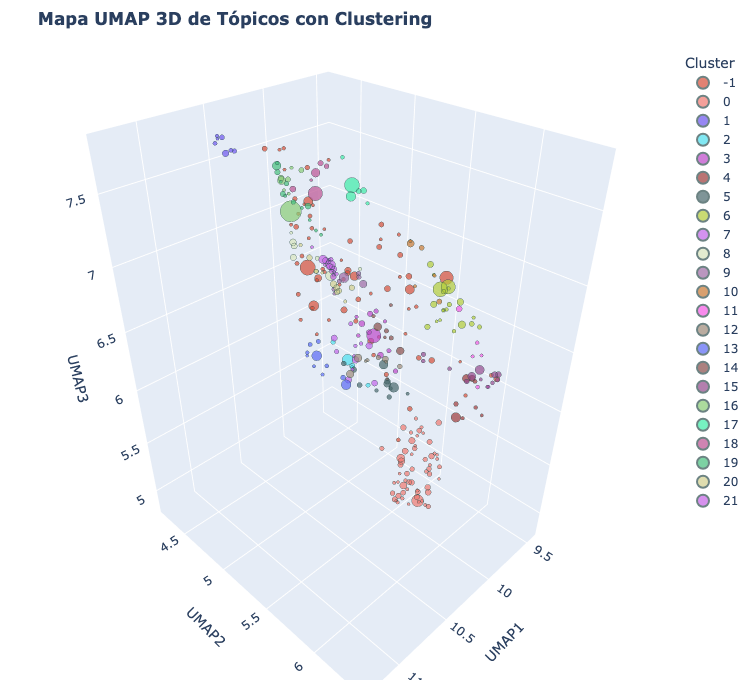

In [26]:
fig_3d, df_umap, embeddings, labels = visualize_topics_umap_clustered_3d(
    topic_model,
    use_ctfidf=False,          # usa embeddings altos
    custom_labels=False,       # muestra las 5 palabras más frecuentes
    umap_high_dim=None,        # se calcula automáticamente al menos 3 dimensiones
    umap_n_neighbors=20,
    umap_metric="cosine",
    hdb_min_cluster_size=5,
    hdb_min_samples=2,
    random_state=42
)

fig_3d.show()

In [34]:
df_embeddings = pd.DataFrame({
    'embeddings': embeddings.tolist(),
    'labels': labels
})
df_embeddings.head()

,embeddings,labels
0,"[-0.09538815170526505, 0.12984858453273773, -0...",16
1,"[0.06388441473245621, 0.05679938569664955, -0....",-1
2,"[0.006098364479839802, 0.2866469621658325, -0....",17
3,"[-0.05712384358048439, 0.14127756655216217, 0....",6
4,"[-0.035633791238069534, 0.06521928310394287, -...",18


In [48]:
(
    df_embeddings
    .groupby('labels')['embeddings']
    .apply(lambda lista_embs: 
           similitud_mediana(np.vstack(lista_embs.values)))
    .reset_index(name='similitud_mediana')
)

,labels,similitud_mediana
0,-1,0.367853
1,0,0.463352
2,1,0.682439
3,2,0.540462
4,3,0.532345
5,4,0.503586
6,5,0.462021
7,6,0.446408
8,7,0.659530
9,8,0.651321


In [15]:
cluster_map = dict(zip(df_umap["Topic"], df_umap["Cluster"]))
words_map = dict(zip(df_umap["Topic"], df_umap["Words"]))

df_topics["cluster"] = df_topics["macrot_id"].map(cluster_map)
df_topics["cluster"] = df_topics["cluster"].fillna(-1)
df_topics["cluster_words"] = df_topics["macrot_id"].map(words_map)
df_topics.head().iloc[:, 1:]

,tid,n_messages,description,keywords,representative_docs,theme,rep_docs_norm,representative_docs_str,macrot_id,cluster,cluster_words
0,0,111,0_vacunamos_novavax_fauci_reacciones,"['vacunamos', 'novavax', 'fauci', 'reacciones'...",[estracto de la agencia europea del medicament...,Conspiracy theories and misinformation about C...,[estracto de la agencia europea del medicament...,estracto de la agencia europea del medicamento...,111,0,deaths | incl | desconocido | casos | disorders
1,1,106,1_encontrado_oficialialistas_mujer_desconectado,"['encontrado', 'oficialialistas', 'mujer', 'de...","[los viajes espaciales, la creacion de una pan...",The theme revolves around conspiracy theories ...,[los viajes espaciales la creacion de una pand...,los viajes espaciales la creacion de una pande...,-1,-1,NaN
2,2,85,2_expreso0demedianoche_directo_anonimo_descarg...,"['expreso0demedianoche', 'directo', 'anonimo',...",[el expreso de media noche directo del 24/02 /...,Unauthorized use of a popular podcast's name a...,[el expreso de media noche directo del 24 02 2...,el expreso de media noche directo del 24 02 21...,-1,-1,NaN
3,3,65,3_despiertos_actuamos_inocencia_hijos,"['despiertos', 'actuamos', 'inocencia', 'hijos...",[da mucho asco ver ciertos personajes que van ...,"Critique of egoism, superficiality, and lack o...",[da mucho asco ver ciertos personajes que van ...,da mucho asco ver ciertos personajes que van d...,80,0,doktor | esra | medical | gmc | dr
4,4,63,4_protestas_republica_belga_cerrados,"['protestas', 'republica', 'belga', 'cerrados'...",[la gente se defiende: suiza fuerza un referé...,Public discontent and resistance against gover...,[la gente se defiende suiza fuerza un referend...,la gente se defiende suiza fuerza un referendu...,64,8,francia | france | macron | sam | french


In [16]:
# Si hay NaN, convíertelos primero a cadena vacía (o a lista vacía)
df_topics["cluster_words"] = df_topics["cluster_words"].fillna("")

# Luego crea la nueva columna aplicando split por " | "
df_topics["cluster_words_list"] = df_topics["cluster_words"] \
    .str.split(r"\s*\|\s*")  # separa por “|” omitiendo espacios alrededor

# Si prefieres que las filas originalmente NaN queden como listas vacías en lugar de [''], puedes filtrar:
df_topics["cluster_words_list"] = df_topics["cluster_words_list"].apply(
    lambda lst: [w for w in lst if w]
)

df_topics.head().iloc[:, 1:]

,tid,n_messages,description,keywords,representative_docs,theme,rep_docs_norm,representative_docs_str,macrot_id,cluster,cluster_words,cluster_words_list
0,0,111,0_vacunamos_novavax_fauci_reacciones,"['vacunamos', 'novavax', 'fauci', 'reacciones'...",[estracto de la agencia europea del medicament...,Conspiracy theories and misinformation about C...,[estracto de la agencia europea del medicament...,estracto de la agencia europea del medicamento...,111,0,deaths | incl | desconocido | casos | disorders,"[deaths, incl, desconocido, casos, disorders]"
1,1,106,1_encontrado_oficialialistas_mujer_desconectado,"['encontrado', 'oficialialistas', 'mujer', 'de...","[los viajes espaciales, la creacion de una pan...",The theme revolves around conspiracy theories ...,[los viajes espaciales la creacion de una pand...,los viajes espaciales la creacion de una pande...,-1,-1,,[]
2,2,85,2_expreso0demedianoche_directo_anonimo_descarg...,"['expreso0demedianoche', 'directo', 'anonimo',...",[el expreso de media noche directo del 24/02 /...,Unauthorized use of a popular podcast's name a...,[el expreso de media noche directo del 24 02 2...,el expreso de media noche directo del 24 02 21...,-1,-1,,[]
3,3,65,3_despiertos_actuamos_inocencia_hijos,"['despiertos', 'actuamos', 'inocencia', 'hijos...",[da mucho asco ver ciertos personajes que van ...,"Critique of egoism, superficiality, and lack o...",[da mucho asco ver ciertos personajes que van ...,da mucho asco ver ciertos personajes que van d...,80,0,doktor | esra | medical | gmc | dr,"[doktor, esra, medical, gmc, dr]"
4,4,63,4_protestas_republica_belga_cerrados,"['protestas', 'republica', 'belga', 'cerrados'...",[la gente se defiende: suiza fuerza un referé...,Public discontent and resistance against gover...,[la gente se defiende suiza fuerza un referend...,la gente se defiende suiza fuerza un referendu...,64,8,francia | france | macron | sam | french,"[francia, france, macron, sam, french]"


Canales por macro-tópico.

In [17]:
df_topics['cluster'] = pd.to_numeric(df_topics['cluster'])

In [18]:
# Nº de canales por cluster
df_topics.groupby('cluster')['_id'].nunique()

cluster
-1     397
 0     263
 1      84
 2     116
 3     184
 4     133
 5     152
 6     156
 7     157
 8     138
 9     126
 10     92
 11     64
 12     82
 13    112
 14    115
 15    158
 16    180
 17    156
 18    128
 19    112
 20    139
 21    128
Name: _id, dtype: int64

In [19]:
# Estadísticas descriptivas sobre el nº de canales por cluster
df_topics.groupby('cluster')['_id'].nunique().describe()

count     23.000000
mean     146.608696
std       68.379116
min       64.000000
25%      113.500000
50%      133.000000
75%      156.500000
max      397.000000
Name: _id, dtype: float64

In [52]:
noise = len(df_topics[df_topics["cluster"] == -1])
noise_perc = round((noise / len(df_topics) * 100), 2)
print(f"{noise_perc} % es ruido")

55.85 % es ruido


In [53]:
# Filter out noise (cluster == -1)
non_noise = df_topics[df_topics['cluster'] != -1]

# Count non-noise topics per channel (_id)
count_per_channel = non_noise.groupby('_id').size().reset_index(name='non_noise_count')

# Count how many channels have more than one non-noise topic
result = (count_per_channel['non_noise_count'] > 1).sum()

print(f"{result} canales de {df_topics['_id'].nunique()} tienen al menos 1 tópico que no es ruido")

350 canales de 404 tienen al menos 1 tópico que no es ruido


In [20]:
df_topics.to_csv("../data/macro_topics.csv", index=False)